# **Project: Solar Cycle**

**Course:** Optimisation and High performance Computing (OHPC-HS25-AD23)  
**Team Members:** Cieplinski Nicole, Plos Penelope, Yeji Huber
**Date:** 16.01.2026

In [15]:
import numpy as np
# Replace numdifftools with JAX:
# import numdifftools as nd
# ---------------------------------
# N.B.:
# Required: conda install -c conda-forge jax jaxlib
# ---------------------------------
import jax.numpy as jnp
from jax import grad

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

## Simulated Annealing (SA) function

### SA function for hyper-parameter tuning

In [16]:
def simulated_annealing_tuning(x0, T0, sigma, f, n_iter = 2e5, thinning = 1):

    x = x0.copy()           # initial x
    T = T0                  # initial temperature
    n_params = x0.shape[0]  # number of parameters to optimized

    # Means and covariance matrix for the jump distribution -> multivariate normal with mean 0 and standard deviation sigma 
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Calculate size of the output array after thinning
    # (thinning -> save states at regular intervals instead of every iteration) 
    # Thinning is by defaut 1, and size_out = n_iter
    size_out = int((n_iter + thinning -1)//thinning)    # equivalent to ceiling (n_iter/thinning)
    v = np.zeros((size_out, n_params))
    # Store the initial parameter array
    v[0,:] = x

    iter_counter = 0
    iter_counter_thin = 0
    print("Initial loss:", f(x))
    #start main loop
    while iter_counter < n_iter:
        iter_counter += 1;
        x_old = x;
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        #Metropolis accept/reject step 
        if np.exp(-np.clip(DeltaE, -100, 100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        
        # Update temperature according to schedule
        T = T0 * (1 - iter_counter/n_iter)
        # Keep track of accepted state
        if iter_counter%1 == 0:
            print("Iteration", iter_counter, " - Temperature:", T, "Loss", f(x))
        if iter_counter%thinning == 0:
            v[iter_counter_thin,:] = x
            iter_counter_thin += 1
    
    return v
    

### SA function for final optimization

In [17]:
def simulated_annealing_optim(x0, T0, sigma, f, n_iter = 2.5e5, burn_in = 2e5):

    x = x0.copy()           # initial x
    T = T0                  # initial temperature
    n_params = x0.shape[0]  # number of parameters to optimized
    
    # means and covariance matrix for the jump distribution -> multivariate normal
    means = np.full(n_params, 0)
    cov_matrix = np.diag(np.full(n_params, sigma))

    # Size of the output array after burn_in
    size_out = int(n_iter - burn_in)
    v = np.zeros((size_out, n_params))
    
    iter_counter = 0
    print("Initial loss:", f(x))
    # Start main loop
    while iter_counter < n_iter:
        iter_counter += 1;
        x_old = x;
        x_proposal = x_old + np.random.multivariate_normal(means, cov_matrix)
        DeltaE = f(x_proposal) - f(x_old)
        # Metropolis accept/reject step
        if np.exp(-np.clip(DeltaE/T, -100,100)) >= np.random.rand():
            x = x_proposal
        else:
            x = x_old
        # Update temperature according to schedule
        T = T0*(1-iter_counter/n_iter)
        # keep track of the algorithm state
        if iter_counter%10 == 0:
            print("Iteration ", iter_counter, " - Temperature:", T, " - Loss:", f(x))
        if iter_counter > burn_in:
            v[iter_counter-int(burn_in)-1, :] = x

    return v 

# Load data

In [18]:
data = np.loadtxt('data_Team9.csv', delimiter=',', skiprows=1) 

In [19]:
data.shape

(39220, 2)

In [20]:
data

array([[1878.15199877,   13.65877439],
       [1878.15477652,   13.22461169],
       [1878.15755428,   14.05492822],
       ...,
       [1987.08717135,    8.53057405],
       [1987.08994911,    3.49094437],
       [1987.09272686,    0.        ]])

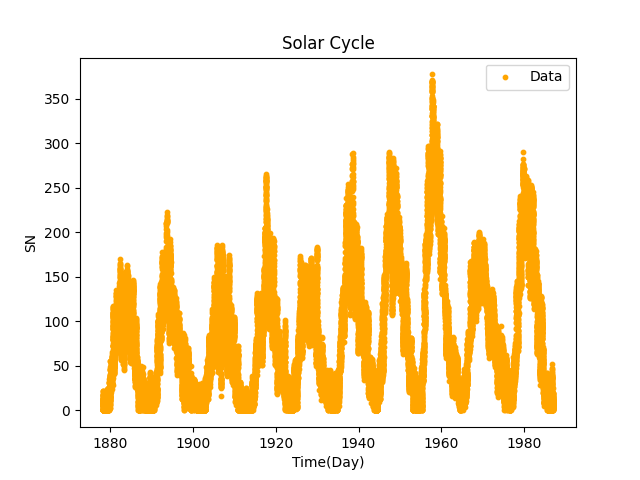

In [21]:
#Plot data for visualization
plt.figure()
plt.scatter(data[:,0], data[:,1], color="Orange", s=10, label= "Data")
plt.xlabel("Time(Day)")
plt.ylabel("SN")
plt.title("Solar Cycle")
plt.legend()
plt.show()

In [36]:
time_points = data[:, 0]
n_data = time_points.shape[0]
data_points = data[:, 1]

print(time_points)
print(n_data)
print(data_points)

[1878.15199877 1878.15477652 1878.15755428 ... 1987.08717135 1987.08994911
 1987.09272686]
39220
[13.65877439 13.22461169 14.05492822 ...  8.53057405  3.49094437
  0.        ]


# Model and Loss Function

### Model

In [ ]:
# parameters 
# Phase 1: T01, Ts1, Td1
# Phase 2: T02, Ts2, Td2 
#...
# Phase 10: T010, Ts10, Td10 
# x0 = np.array([Ts1, Td1, Ts2, Td2, ...])

x0 = np.array([3.0, 0.1, 2.0, 0.05, 1.5, 0.01, 1.0, 0.005, 0.7, 0.001, 0.5, 0.0005, 0.3, 0.0001, 0.1, 0.00005, 0.05, 0.00001, 0.02, 0.000005])

In [29]:
# The different parameters can be extracted as follows:
Ts = x0[::2]
Td = x0[1::2]

print(Ts)
print(Td)

# Number of phases
num_phases = len(Ts)
num_phases

[3.   2.   1.5  1.   0.7  0.5  0.3  0.1  0.05 0.02]
[1.e-01 5.e-02 1.e-02 5.e-03 1.e-03 5.e-04 1.e-04 5.e-05 1.e-05 5.e-06]


10

In [53]:
# make TO array
T0array = np.array([0, 3922, 7844, 11766, 15688, 19610, 23532, 27454, 31376, 35298, 39220])
# Create list of time intervals for each phase
intervals = [(float(T0array[ix]),float(T0array[ix+1])) for ix in range(num_phases)]

print(intervals)

[(0.0, 3922.0), (3922.0, 7844.0), (7844.0, 11766.0), (11766.0, 15688.0), (15688.0, 19610.0), (19610.0, 23532.0), (23532.0, 27454.0), (27454.0, 31376.0), (31376.0, 35298.0), (35298.0, 39220.0)]


In [54]:
# We will use a loop to process all phases
for ix, (a, b) in enumerate(intervals):
    print("Processing phase", ix+1, "with interval (", a, ",", b, ")")

Processing phase 1 with interval ( 0.0 , 3922.0 )
Processing phase 2 with interval ( 3922.0 , 7844.0 )
Processing phase 3 with interval ( 7844.0 , 11766.0 )
Processing phase 4 with interval ( 11766.0 , 15688.0 )
Processing phase 5 with interval ( 15688.0 , 19610.0 )
Processing phase 6 with interval ( 19610.0 , 23532.0 )
Processing phase 7 with interval ( 23532.0 , 27454.0 )
Processing phase 8 with interval ( 27454.0 , 31376.0 )
Processing phase 9 with interval ( 31376.0 , 35298.0 )
Processing phase 10 with interval ( 35298.0 , 39220.0 )


In [ ]:
# Model function
def model

### Loss function

In [23]:
# Loss function
def mse(x):
    return np.mean(np.square(data_points - model(time_points, x)))

NameError: name 'model' is not defined

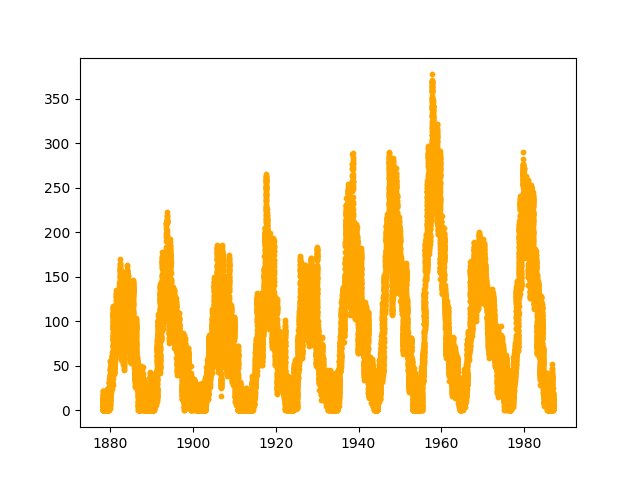

In [14]:
# Visualisation
plt.figure()
plt.scatter(time_points, data_points, color='orange', s=10)
plt.plot(time_points, model(time_points, x0), color='blue', linestyle='--', linewidth=1)
plt.show(block=False)

# Initial mse:
mse(x0)

# Hyper-parameters tuning

In [ ]:
T0 = 1
sigma = 1
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

In [ ]:
T0 = 1
sigma = 0.1
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

In [ ]:
T0 = 1
sigma = 0.01
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

In [ ]:
T0 = 1
sigma = 0.00001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

In [ ]:
T0 = 10
sigma = 0.00001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

In [ ]:
T0 = 0.5
sigma = 0.00001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

In [ ]:
T0 = 0.2
sigma = 0.00001
outSA = simulated_annealing_tuning(x0, T0, sigma, mse, n_iter = 1e3, thinning = 1)

plt.figure()
mse_curve = np.apply_along_axis(mse, 1, outSA)
plt.plot(mse_curve)
plt.show(block = False)

mse(outSA[-1])

Optimal hyper-parameter values are :<br>
T0 = <br>
sigma = <br>

In [ ]:
# Check the final state of the tuning process

plt.figure()
plt.scatter(time_points, data_points, color='oragne', s=20)
plt.plot(time_points, model(time_points, outSA[-1]), color='blue')
plt.show(block=False)

# Final optimization

In [ ]:
#initial condition
x0_from_tuning = outSA[-1]

# Number of chains for final optimization
n_chains = 10
# Perturb the initial condition for each chain
x0noisy = np.abs(x0_from_tuning + np.random.normal(0, np.tile(np.array([0.01, 1, 0.0005]), 3), (n_chains, 9))) # abs avoids negative numbers

T0 = 0.2
sigma = 1e-5

n_iter = 1500
burn_in = 1000

In [ ]:
results = np.empty((int(n_chains*(n_iter - burn_in)),9))

for ix in range(n_chains):

    opt = simulated_annealing_ optim(x0noisy[ix], T0, sigma, mse, burn_in = burn_in, n_iter = n_iter)
    start_idx = ix * opt.shape[0]
    end_idx = start_idx + opt.shape[0]
    # write the 'opt' output directly into the allocated array
    results[start_idx : end_idx, :] = opt
    

In [ ]:
results

In [ ]:
n_params = 9

In [ ]:
center_of_mass = np.zeros(n_params)
for ix in range(n_params):
    counts, bin_edges = np.histogram(chain[:,ix], bins=20)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Calculate the center of mass
   # Weights are the counts of each bin
    center_of_mass[ix] = np.sum(counts * bin_centers) / np.sum(counts)

In [ ]:
plt.figure()
plt.scatter(time_points, data_points, color ='orange', s=10)
plt.plot(time_points, model(time_points, *params), color='blue')
plt.show(block=False)

In [ ]:
center_of_mass

In [ ]:
#correct manually for the first time-point
center_of_mass[0] = 0

In [ ]:
plt.figure()
plt.scatter(time_points, data_points, color ='orange', s=10)
plt.plot(time_points, model(time_points, *params), color='blue')
plt.show(block=False)